# [Pytorch系列-61]：生成对抗网络GAN - 基本原理 - 自动生成手写数字案例分析

In [51]:
import os
import numpy as np
import math
import random

import matplotlib.pyplot as plt # 画图库

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

import torchvision.utils as utils 
import torch.utils.data as data_utils  #对数据集进行分批加载的工具集


cuda = True if torch.cuda.is_available() else False
print(cuda)

False


In [52]:
Configure data loader
os.makedirs("./data/mnist", exist_ok=True)

img_size = 28
batch_size = 64

# 数据转换
tensor_transform = transforms.Compose([transforms.Resize(img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])
print(tensor_transform)

# 自动下载minist数据集
train_data = datasets.MNIST("./data/mnist",
                            train=True,
                            download=True,
                            transform = tensor_transform)
print(train_data)

Compose(
    Resize(size=28, interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
    Normalize(mean=[0.5], std=[0.5])
)
Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data/mnist
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=28, interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )


Define Dataloader and read data via dataloader

1. images.transpose(1, 2, 0): 这是一个转置操作，用于重新排列images张量的维度。在转置操作中，(1, 2, 0)表示将原始张量的第1维度移动到第0位，第2维度移动到第1位，而原始的第0维度移动到新张量的第2位。这个操作的目的是将张量从PyTorch的格式(C, H, W)转换为imshow函数能够接受的格式(H, W, C)。在imshow函数中，通常使用这种格式来显示图像。

2. images = utils.make_grid(imgs): make_grid函数将imgs批次中的图像合并成一张网格状图像。该函数会自动将图像排列成行和列，形成一个视觉上美观的网格。值得注意的是，imgs批次应该是特定格式的数据，通常是张量或NumPy数组。

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Extract a batch of pictures
torch.Size([64, 1, 28, 28])
torch.Size([64])
64

合并成一张三通道灰度图片
torch.Size([3, 242, 242])
torch.Size([64])

转换成imshow格式
(242, 242, 3)
torch.Size([64])

显示样本标签
tensor(4)tensor(8)tensor(8)tensor(6)tensor(7)tensor(1)tensor(0)tensor(7)
tensor(1)tensor(8)tensor(7)tensor(6)tensor(4)tensor(9)tensor(1)tensor(5)
tensor(3)tensor(2)tensor(6)tensor(8)tensor(8)tensor(6)tensor(9)tensor(4)
tensor(6)tensor(0)tensor(4)tensor(2)tensor(6)tensor(7)tensor(0)tensor(5)
tensor(8)tensor(6)tensor(0)tensor(3)tensor(5)tensor(7)tensor(4)tensor(7)
tensor(5)tensor(1)tensor(6)tensor(7)tensor(3)tensor(6)tensor(0)tensor(3)
tensor(1)tensor(1)tensor(2)tensor(6)tensor(7)tensor(9)tensor(8)tensor(0)
tensor(7)tensor(2)tensor(4)tensor(3)tensor(6)tensor(5)tensor(9)tensor(5)

显示图片


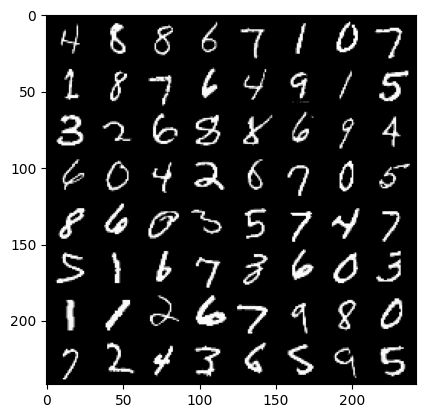

In [53]:
# 为数据集启动data loader
dataloader = torch.utils.data.DataLoader(train_data,batch_size = batch_size, shuffle=True)
print(dataloader)

# Show pictures of one batch 
print("Extract a batch of pictures")
imgs, labels = next(iter(dataloader))
print(imgs.shape)
print(labels.shape)
print(labels.size()[0])

print('\n合并成一张三通道灰度图片')
images = utils.make_grid(imgs)
print(images.shape)
print(labels.shape)

print("\n转换成imshow格式")
images = images.numpy().transpose(1,2,0)
print(images.shape)
print(labels.shape)

print("\n显示样本标签")
#打印图片标签
for i in range(64):
    print(labels[i], end="")
    i +=1
    if i%8==0:
        print(end='\n')
        
print("\n显示图片")
plt.imshow(images)
plt.show()

## 3.4 自定义数据集标签

In [54]:
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor 

print(imgs.size())
print(imgs.size()[0])
# 原始的参考样本的标签为1
valid = Variable(Tensor(imgs.size(0),1).fill_(1.0), requires_grad = False)

#生成图片的标签为0
fake = Variable(Tensor(imgs.size(0),1).fill_(0.0), requires_grad=False)
print(fake.shape)
print(valid.shape)

#print(imgs.type(Tensor))
real_imgs = Variable(imgs.type(Tensor))
print(real_imgs.shape)

torch.Size([64, 1, 28, 28])
64
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1, 28, 28])


# 第4章 定义网络


## 4.1 定义网络参数

In [55]:
latent_dim = 100

channels = 1
img_shape = (channels, img_size, img_size)

## 4.2 定义生成网络

In [56]:
# 定义生成图片的模型
# 输入：
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        def block(in_feat, out_feat, normalize = True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat,0.8))
            layers.append(nn.LeakyReLU(0.2, inplace = True))
            return layers 
        
        self.model = nn.Sequential(
            * block(latent_dim, 128, normalize = False),
            * block(128,256),
            * block(256, 512),
            * block(512, 1024), 
            nn.Linear(1024, int(np.prod(img_shape))), 
            nn.Tanh()          
        )
        
    def forward(self,z):
        img = self.model(z)
        img = img.view(img.size(0), * img_shape)
        return img

In [57]:
# 实例化生成网络的模型
# Initialize generator and discriminator
generator = Generator()
# 生成网络的输入输出
# 输入：长度为100的一维向量，在整个训练过程中，
#       输入图片虽然是随机产生的，但在训练过程中是不一直不变的。
#       
# 输出：1 * 28 * 28 的图片
print(generator)

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=1024, out_features=784, bias=True)
    (12): Tanh()
  )
)


### （3）测试网络

In [58]:
seed = 1

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# 获取当前GPU或CPU的device 
device = torch.device( "cuda:0" if torch.cuda.is_available() else "cpu")

# 定义随机样本，作为生成网络的输入
# 也可以采用其他样本，作为生成网络的输入
input = Variable(Tensor(np.random.normal(0,1, (batch_size, latent_dim))))

# 部署到GPU上预测
input = input.to(device)
print(input.shape)
print(input)

# 生成一个批图片
# W，B的参数不同，生成的图片不同
# 在训练的过程中，不断的调整W,B的参数，输出的图片就不断的变换
# 在训练过程中，输入图片是不变的（其值是由随机产生的随机数，也可以是有一定意义的图片）
generator.to(device)  
output = generator(input)
print(output.shape)

torch.Size([64, 100])
tensor([[ 1.6243, -0.6118, -0.5282,  ...,  0.0436, -0.6200,  0.6980],
        [-0.4471,  1.2245,  0.4035,  ...,  0.4203,  0.8110,  1.0444],
        [-0.4009,  0.8240, -0.5623,  ...,  0.7848, -0.9554,  0.5859],
        ...,
        [ 0.3523,  0.0450,  1.8180,  ...,  0.2559, -0.6614, -0.4892],
        [-1.0460,  0.5973,  0.6259,  ...,  0.4243,  0.3902,  2.0044],
        [ 0.7353, -0.2814, -1.4044,  ...,  2.3529,  1.0682, -1.8938]])
torch.Size([64, 1, 28, 28])


## 4.3 定义判决网络

### （1）定义网络结构

1. nn.Linear(int(np.prod(img_shape)), 512) 这里创建了一个线性层（全连接层），将生成器的输出进行线性变换，从形状'(batch_size, channels, height, width)' 转换为形状 (batch_size, 512)。中各个维度的元素乘积，得到生成器输出的总维度。int 强制转换为整数，以便在构建线性层时使用。

In [59]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)),512), # (784, 512)
            nn.LeakyReLU(0.2, inplace = True),
            nn.Linear(512,256),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Linear(256,1),
            nn.Sigmoid(),
        )
    
    def forward(self, img):
        img_flat = img.view(img.size(0),-1)
        validity = self.model(img_flat)
        return validity 

### （2）实例化网络

In [60]:
# 实例化判决判决神经网络
# 输入：728 = 1 * 28 * 28
# 输出：1 =》 1分类， 1表示图片为真，0表示图片为假
discriminator = Discriminator()
discriminator.to(device)
print(discriminator)

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


### （3）测试网络

In [61]:
y = discriminator(output)
print(y.shape)
print(y[0])

# 使用判决网络对训练图片进行预测
imgs = imgs.to(device)
y = discriminator(imgs)
print(y.shape)
print(y[0])

torch.Size([64, 1])
tensor([0.5092], grad_fn=<SelectBackward0>)
torch.Size([64, 1])
tensor([0.4943], grad_fn=<SelectBackward0>)


# 第5章 模型训练

## 5.1 定义训练参数

In [62]:
# 定义存放自动生成图片的路径
os.makedirs("images", exist_ok = True)

# 定义模型训练的超参数
n_epochs = 100
lr = 0.0002
b1 = 0.5
b2 = 0.999
n_cpu = 8

# 定义存放生成文件的间隔 （样本数间隔，而不是时间间隔）
sample_interval = 500

# 定义列表，存放训练过程中的loss
loss_g = []
loss_d = []

## 5.2 定义loss

In [63]:
# Define loss function
adversarial_loss = torch.nn.BCELoss()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()
    
# Optimizers
optimizer_G=torch.optim.Adam(generator.parameters(),lr=lr,betas=(b1,b2))
optimizer_D=torch.optim.Adam(discriminator.parameters(),lr=lr,betas=(b1,b2))

## 5.3 训练网络

1. detach() 方法的作用是将 gen_imgs 与生成器的计算图分离，从而保持生成器的梯度不传递到判别器。这样，判别器只关注虚假图像而不会对生成器的参数造成影响。

In [67]:
# ----------------
# --- Training ---
# ----------------

for epoch in range(n_epochs):
    # 读取一个batch的数据
    for i, (imgs, _) in enumerate(dataloader):
        seed = 1
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        # Adversarial groud truths 
        # 获取当前dataloader imgs的batch size
        tmp_batch_size = imgs.size(0)
        
        # 建训练所需要的标签
        # 真实图片的标签全部为1
        valid = Variable(Tensor(tmp_batch_size,1).fill_(1.0), requires_grad=False)
        # 真实图片的标签全部为0
        fake = Variable(Tensor(tmp_batch_size,1).fill_(0.0), requires_grad=False)
        
        # -------------------------
        # ---- Train Generator ----
        # -------------------------
        # 复位G网络的梯度值
        optimizer_G.zero_grad()
        
        # Sample noise as generator input
        # 生成与真实图片相同batch的输入向量
        # 这里的输入是latent_dim=100长度的一维向量，向量的值为随机值
        # 随机值在每次迭代时会发生变化吗？
        input = Variable(Tensor(np.random.normal(0,1,(imgs.shape[0], latent_dim))))
        
        # Generate a batch of images
        # 用相同的生成网络，针对不同的批样本输入，生成一批不同的图片
        gen_imgs = generator(input)   
        # 对生成的图片进行预测
        y_gen = discriminator(gen_imgs)
        
        # Loss measures generator's ability to fool the discriminator
        # 目标是：使得当前G网络生成的图片，骗过当前的判决网络D, 判决为真实图片
        # 每次迭代：G网络进化一点点，即使得g_loss降低一点点
        # 由于每次迭代, D网络也在进化，导致g_loss再提升一点点
        # g_loss反应的是：使用当前的D网络，判断G网络生成的图片，是不是真实图片中的一个
        # g_loss越小，生成的图片越接近真实的图片中的一个
        g_loss = adversarial_loss(y_gen, valid)
        
        # 求G网络的梯度
        g_loss.backward()
        
        # 反向迭代生成网络G，只迭代G网络的W，B参数
        optimizer_G.step() 
        loss_g.append(g_loss.item())
        
        
        
        # ------------------------------------
        # ---------- Train Discriminator -----
        # ------------------------------------
        # 判决网络通过提高鉴别能力，朝着尽可能能够区分真实图片和生成图片的方向迭代、进化
        optimizer_D.zero_grad()
        # Measure discriminator's ability to classify real from generated samples
        # 用真实图片进行预测
        # Configure input
        real_imgs = Variable(imgs.type(Tensor))
        
        # 判决对生成图片进行判决: 尽可能识别生成图片与真实图片的差别
        # 优化判决网络，尽可能使得判决网络把真实图片判定为1， 因此使用了标签1
        y_real = discriminator(real_imgs)
        real_loss = adversarial_loss(y_real, valid)
        
        # 优化判决网络，尽可能使得判决网络把生成图片判定为0，因此使用了标签0
        y_gen = discriminator(gen_imgs.detach())
        fake_loss = adversarial_loss(y_gen, fake)
        
        d_loss = (real_loss+fake_loss)/2
        
        # 判决网络D的反向求导
        d_loss.backward()
        
        # 反向迭代判决网络D
        optimizer_D.step() 
        loss_d.append(d_loss.item())
        
        # 每隔sample_interval=400个生成样本，存储一个到文件中
        batches_done = epoch * len(dataloader) + i
        
        if batches_done % sample_interval == 0:
            #save_image(gen_imgs.data[:25], "images/%d.png" % batch_done, nrow=5, normalize=True)
            #存储一个batch中的所有生成图片，每行8张图片
            save_image(gen_imgs.data[:], "images/%d.png" % batches_done, nrow=8, normalize=True)
            
            print( "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                    % (epoch, n_epochs, i, len(dataloader), d_loss.item(), g_loss.item()))
            #print(input.shape)
            #print(input)
            
print("Done")    


[Epoch 0/100] [Batch 0/938] [D loss: 0.403804] [G loss: 1.695851]
[Epoch 0/100] [Batch 500/938] [D loss: 0.425399] [G loss: 2.223280]


KeyboardInterrupt: 

In [72]:
# ------------------
# ---- Training ----
# ------------------

for epoch in range(n_epochs):
    for i, (imgs,_) in enumerate(dataloader):
        seed = 1
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        
        # Adversarial ground truths
        tmp_batch_size = imgs.size(0)
        valid = Variable(Tensor(tmp_batch_size,1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(tmp_batch_size,1).fill_(0.9), requires_grad=False)
        
        # ---- Train Generator ----
        optimizer_G.zero_grad()
        input_ = Variable(Tensor(np.random.normal(0,1,(imgs.shape[0], latent_dim))))
        gen_imgs = generator(input_)
        y_gen = discriminator(gen_imgs)
        g_loss = adversarial_loss(y_gen, valid)
        g_loss.backward()
        optimizer_G.step()
        loss_g.append(g_loss.item())
        
        # ---- Train Discriminator ----
        optimizer_D.zero_grad()
        real_imgs = Variable(imgs.type(Tensor))
        y_real = discriminator(real_imgs)
        real_loss = adversarial_loss(y_real, valid)
        y_fake = discriminator(gen_imgs.detach())
        fake_loss = adversarial_loss(y_fake, fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()
        loss_d.append(d_loss.item())
        
        batches_done = epoch * len(dataloader) + i
        if batches_done % sample_interval == 0:
            save_image(gen_imgs.data[:], "images/%d.png" % batches_done, nrow=8, normalize=True)
            print( "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                    % (epoch, n_epochs, i, len(dataloader), d_loss.item(), g_loss.item()))
            #print(input.shape)
print("Done")   

[Epoch 0/100] [Batch 0/938] [D loss: 0.181200] [G loss: 0.078777]
[Epoch 0/100] [Batch 500/938] [D loss: 0.178193] [G loss: 0.072869]
[Epoch 1/100] [Batch 62/938] [D loss: 0.176755] [G loss: 0.087099]
[Epoch 1/100] [Batch 562/938] [D loss: 0.178834] [G loss: 0.068738]
[Epoch 2/100] [Batch 124/938] [D loss: 0.177637] [G loss: 0.080088]
[Epoch 2/100] [Batch 624/938] [D loss: 0.182596] [G loss: 0.088780]
[Epoch 3/100] [Batch 186/938] [D loss: 0.182142] [G loss: 0.104558]
[Epoch 3/100] [Batch 686/938] [D loss: 0.179810] [G loss: 0.072484]
[Epoch 4/100] [Batch 248/938] [D loss: 0.183422] [G loss: 0.078104]
[Epoch 4/100] [Batch 748/938] [D loss: 0.183054] [G loss: 0.064979]
[Epoch 5/100] [Batch 310/938] [D loss: 0.183624] [G loss: 0.083253]
[Epoch 5/100] [Batch 810/938] [D loss: 0.180343] [G loss: 0.066506]
[Epoch 6/100] [Batch 372/938] [D loss: 0.180320] [G loss: 0.069337]
[Epoch 6/100] [Batch 872/938] [D loss: 0.189809] [G loss: 0.082524]
[Epoch 7/100] [Batch 434/938] [D loss: 0.187083] [G

# 第6章 模型预测与评估

## 6.1 显示g网络loss

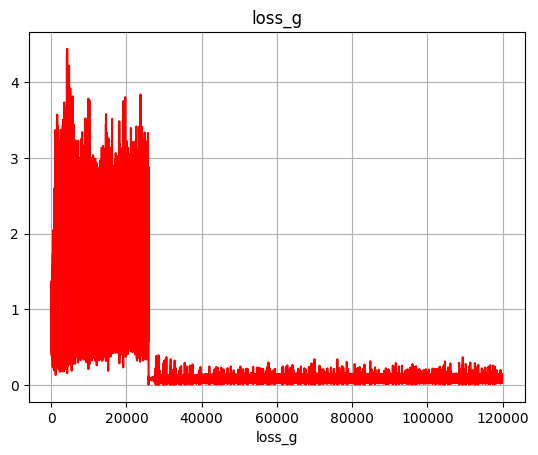

In [74]:
# 显示迭代过程中loss的变换过程
plt.grid()
plt.xlabel("loss_g")
plt.ylabel("")
plt.title("loss_g", fontsize = 12)
plt.plot(loss_g, "r")

## 6.2 显示D网络loss

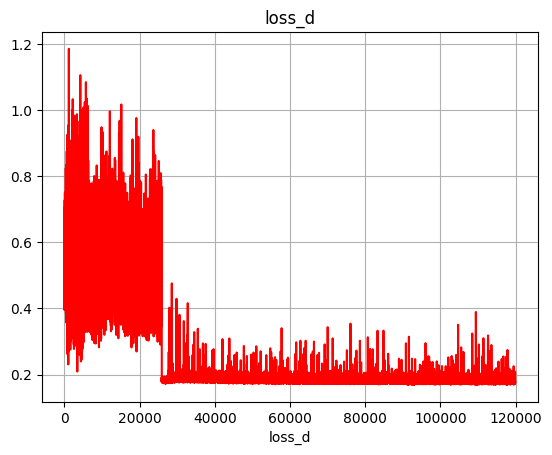

In [75]:
# 显示迭代过程中loss的变换过程
plt.grid()
plt.xlabel("loss_d")
plt.ylabel("")
plt.title("loss_d", fontsize = 12)
plt.plot(loss_d, "r")
plt.show()

## 6.3 自动生成图片测试

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 100])
torch.Size([64, 1, 28, 28])

合并成一张三通道灰度图片
torch.Size([3, 242, 242])

转换成imshow格式

显示图片


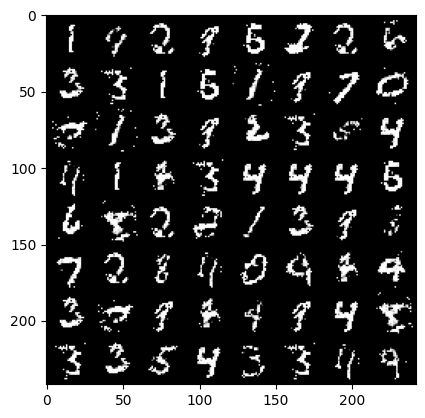

In [76]:
# 生成图片
seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# 获取当前GPU或CPU的device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 定义随机样本，作为生成网络的输入
# 也可以采用其他样本，作为生成网络的输入
input_ = Variable(Tensor(np.random.normal(0,1, (batch_size, latent_dim))))

# 部署到GPU上预测
input_ = input_.to(device)
print(input_.shape)

# 生成一个批图片
# W，B的参数不同，生成的图片不同
# 在训练的过程中，不断的调整W,B的参数，输出的图片就不断的变换
generator.to(device)
imgs = generator(input_)
print(imgs.shape)

print("\n合并成一张三通道灰度图片")
images = utils.make_grid(imgs)
print(images.shape)

print("\n转换成imshow格式")
images = images.to('cpu')
images = images.numpy().transpose(1,2,0)

print("\n显示图片")
plt.imshow(images)
plt.show()

---

## Step 1: Data Generation to learn the GAN 

Simulate log returns via monte carlo simulaton. We will do this by usual Monte Carlo simulation to look at the potential evolution of aaset prices over time, assuming they are subject to daily returns that follows a normal distribution. To set up our simulation, we need to estimate the expected level of return (mu) and volatility (vol) of the stock.  

In [28]:
# Import library 
import numpy as np
import pandas as pd 
import math 
from pandas_datareader import data

import tensorflow as tf
# from tensorflow.contrib.rnn import LSTMCell
#tf.logging.set_verbosity(tf.logging.ERROR)

In [6]:
import datetime as dt
import yfinance as yf

company = 'AFI.AX'
# Define a start date and End Date
start = dt.datetime(2013,1,1)
# Read Stock Price Data 
apple = yf.download(company, start)

[*********************100%***********************]  1 of 1 completed


In [16]:
days = (apple.index[-1] - apple.index[0]).days 
((apple['Adj Close'][-1] / apple['Adj Close'][1]) ** (365.0/days))-1 

0.06722862162468868

In [19]:
# Calculate the compount annual growth rate (CAGR) which will guve us our mean return input (mu)
days = (apple.index[-1] - apple.index[0]).days 
cagr = ((apple['Adj Close'][-1] / apple['Adj Close'][1]) ** (365.0/days))-1 
print('CAGR =', str(round(cagr,4)*100)+'%')

# mu mean return. expected level of return 
mu = cagr

CAGR = 6.72%


In [20]:
# Create a series of percentage returns and calculate the annual volatility of returns

T = 9 # Number of trading days 
apple['Returns'] = apple['Adj Close'].pct_change()
vol = apple['Returns'].std()*math.sqrt(T)
print("Annual Volatility =", str(round(vol,4)*100)+'%')

Annual Volatility = 3.88%


In [21]:
# 3. Generation of the data used to train the GAN

# 3.1 Define variables 
S = apple['Adj Close'][-1] # starting stock price (i.e. last variable real stock price)

n_samples = 50000
seq_length = 10 # change line 202 and 227 as well 

# 3.2 log return
def sample_data(n_samples = n_samples):
    vectors = []
    #### MONTE CARLO ####
    for i in range(n_samples):
        # create list of daily returns using random normal distribution
        daily_returns = np.random.normal(mu/T, vol/math.sqrt(T), seq_length)
        # T+1 since we work with the vectors =[] and do not initialize it by [S]
        vectors.append(np.log(daily_returns+1))
        
    dataset = np.array(vectors)
    dataset.reshape(-1,seq_length,1)
    
    return dataset

In [24]:
samples = sample_data(n_samples = n_samples)
samples.shape # samples.shape

(50000, 10)

## Step 2: Define the networks for the GAN 

In [25]:
# 1. function for getting one mini batch 
def get_batch(samples, batch_size, batch_idx):
    start_pos = batch_idx * batch_size 
    end_pos = start_pos +batch_size 
    return samples[start_pos, end_pos]

In [30]:
tf.compat.v1.reset_default_graph() 

In [31]:
print("loading data")
samples = sample_data(n_samples = n_samples) # samples.shape=(50000, 10)
print("Data loaded")

loading data
Data loaded


In [34]:
# Training configuration
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

print("Loading settings")

learning_rate = 0.001
lr = learning_rate
batch_size = 128
# cond = 0
latent_dim = 20
num_epochs = 50
vis_freq = 2
labels = None 

D_rounds = 3
G_rounds = 1
hidden_units_g = 150
hidden_units_d = 150
num_generated_features = 1

CG = tf.placeholder(tf.float32, [batch_size, seq_length]) #Placeholder 0 (shape: (50,253)) is it 0 or seq_length
CD = tf.placeholder(tf.float32, [batch_size, seq_length]) #Placeholder 1 
Z  = tf.placeholder(tf.float32, [batch_size, seq_length, latent_dim]) #Placeholder 2
W_out_G = tf.Variable(tf.truncated_normal([hidden_units_g, num_generated_features]))
b_out_G = tf.Variable(tf.truncated_normal([num_generated_features]))

X = tf.placeholder(tf.float32, [batch_size, seq_length, num_generated_features])
W_out_D = tf.Variable(tf.truncated_normal([hidden_units_d, 1]))
b_out_D = tf.Variable(tf.truncated_normal([1]))

print("Settings loaded")

Loading settings
Settings loaded


---

In [5]:
# Import modulues and specifting model input dimensions
%matplotlib inline 

import matplotlib.pyplot as plt
import numpy as np

from keras.datasets import mnist 
from keras.layers import Dense, Flatten, Reshape
from keras.layers import LeakyReLU
from keras.models import Sequential 
from keras.optimizers import Adam 

In [6]:
# Model Input dimensions
img_rows = 28
img_cols = 28
channels = 1

img_shape = (img_rows, img_cols, channels) # Input image dimensions 
z_dim = 100 # Size of the noise vector, used as input to the Generator 

## 2. Implementing the Generator 
1. Generator is a neural network with only a single hidden layer. 

2. Input z is produced as 28*28*1 image

3. Activation function: Leaky ReLU, Leaky, which allows a small positive gradient. 

4. Output layer: tanh activation function, which scales the output values to the range [-1,1] 

-----

Discriminator :

5. The discriminator takes in a `28 *28*1` image and outpurs a probability indicating whether the input os deemed real rather than fake. 

6. Two-layer neural network, with 128 hidden units and a Leaky ReLU activation function at the hidden layer. 

7. We apply the sigmoid activation function at the Discriminator's output layer to ensuers that our output value will be between 0 and 1, so it can be interpreted as the probability the Generator assigns that the input is real.


In [ ]:
# Define Generator
def build_generator(img_shape, z_dim):
    model = Sequential()
    model.add(Dense(128, input_dim = z_dim))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(28*28*1, activation ='tanh'))
    model.add(Reshape(img_shape)) # reshapes the generator output to image dimensions 
    return model 

def build_discriminator(img_shape):
    model = Sequential()
    model.add(Flatten(input_shape=img_shape))
    
    